# 1.Neural Networks
## Define the network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#input img size = 32 * 32
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3*3 square convolution, kernel
        self.conv1 = nn.Conv2d(1,6,3) #default:stride=1,padding=0,dilation=1,bias=True
        self.conv2 = nn.Conv2d(6,16,3)
        # an affine operation: y=Wx+b
        self.fc1=nn.Linear(16*6*6,120) #6*6 from inage dimension
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        #Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        #if the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self,x):
        size = x.size()[1:] #all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) #conv1's.weight
print(params[1].size()) #conv1's.bias

10
torch.Size([6, 1, 3, 3])
torch.Size([6])


In [3]:
input = torch.randn(1,1,32,32)
#conv1 and maxpooling make the size of input 15*15. That is a mistake.
out = net(input)
print(out)

tensor([[-0.0609,  0.0050,  0.0317, -0.0095, -0.0261, -0.0015,  0.0684,  0.1522,
         -0.0067,  0.0763]], grad_fn=<AddmmBackward>)


In [4]:
net.zero_grad()
out.backward(torch.randn(1,10))

## Loss Function

In [14]:
output = net(input)
target = torch.randn(10) # a dummy target, for example
target = target.view(1,-1) # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.3813, grad_fn=<MseLossBackward>)


In [15]:
print(loss.grad_fn) #MSELoss
print(loss.grad_fn.next_functions[0][0]) #Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0]) #ReLU

## Backprop

In [16]:
print('no preprocess')
print(net.conv1.bias.grad)

net.zero_grad() #zeros the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

no preprocess
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0024,  0.0012,  0.0009, -0.0079,  0.0006, -0.0021])


## Update the weights

In [17]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [18]:
import torch.optim as optim

#create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

#in your training loop:
optimizer.zero_grad() #zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() #does the update

# 2.Training a classifier
## What about data
Generally, when you have to deal tiwh data, you can use standard python packages \
that load data into a numpy array. Then you can convert this array into a torch.Tensor.\
Specifically for vision, "torchvision, torchvision.datasets and torch.utils.data.DataLoader" are useful.

For this tutorial, we use the CIFAR10 dataset.

## Training an image classifier
1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
# the output of torchvision datasets are PILImage of range[0,1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset=torchvision.datasets.CIFAR10(root='./data',train=True,
                                     download=True, transform=transform)
trainloader=torch.utils.data.DataLoader(
    trainset,batch_size=4,shuffle=True,num_workers=2)

testset=torchvision.datasets.CIFAR10(root='./data',train=False,
                                    download=True, transform=transform)
testloader=torch.utils.data.DataLoader(
    testset,batch_size=4,shuffle=False,num_workers=2)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

0it [00:00, ?it/s]

100%|█████████▉| 170483712/170498071 [01:14<00:00, 1554735.56it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [01:30, 1554735.56it/s]                               

In [6]:
print(trainset)
print(trainloader)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


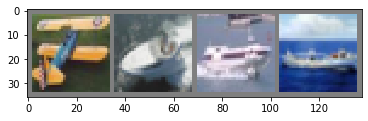

plane  ship  ship  ship


In [9]:
import matplotlib.pyplot as plt
import numpy as np

#func to show an image

def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
#get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
net = Net()

### 3. Define a Loss function and optimizer

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [13]:
for epoch in range(2): #loop over the dataset multiple times
    
    running_loss = 0.0
    for i,data in enumerate(trainloader, 0): #i starts from 0
        #get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i%2000==1999: #print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1,i+1,running_loss/2000))
            running_loss=0.0
            
print('Finishied Training')

[1,  2000] loss: 2.168
[1,  4000] loss: 1.865
[1,  6000] loss: 1.699
[1,  8000] loss: 1.604
[1, 10000] loss: 1.521
[1, 12000] loss: 1.450
[2,  2000] loss: 1.381
[2,  4000] loss: 1.369
[2,  6000] loss: 1.322
[2,  8000] loss: 1.298
[2, 10000] loss: 1.267
[2, 12000] loss: 1.294
Finishied Training


In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(),PATH)

### 5. Test the network on the test data

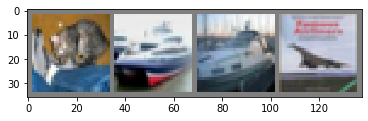

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter=iter(testloader)
images, labels = dataiter.next()

#print iamges
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1) #torch.Size([4,10])
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' %(
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [37]:
#the accuracy of each categories
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1) #torch.Size([4,10])
        c=(predicted==labels).squeeze()
        for i in range(4):
            label=labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
        
for i in range(10):   
    print('Accuracy of %5s : %2d %%' %(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 69 %
Accuracy of  bird : 51 %
Accuracy of   cat : 46 %
Accuracy of  deer : 43 %
Accuracy of   dog : 26 %
Accuracy of  frog : 73 %
Accuracy of horse : 59 %
Accuracy of  ship : 78 %
Accuracy of truck : 61 %


True